In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

#Plots
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

# Measures

In [2]:
#-------Group Fairness--------
def group_fairness(df, sensible_attribute, privileged_value, outcome):
    return df[df[sensible_attribute] != privileged_value][outcome].mean() / df[df[sensible_attribute] == privileged_value][outcome].mean()



#-------Historical Bias-------
def chi_square_test(observed, expected):
    eps = 1e-5
    observed_frequencies = np.array([(100 * value) + eps for key, value in observed.items()])
    expected_frequencies = np.array([(100 * value) + eps for key, value in expected.items()])
    chi2, p, _, _ = chi2_contingency([observed_frequencies, expected_frequencies])
    if p < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

def bhattacharyya_coef(observed, expected):
    eps = 1e-5
    observed_frequencies = np.array([(100 * value) + eps for key, value in observed.items()])
    expected_frequencies = np.array([(100 * value) + eps for key, value in expected.items()])
    return np.sum([np.sqrt(observed_frequencies[i]*expected_frequencies[i]) for i in range(len(expected_frequencies))])

In [3]:

def edit_group_fairness(df, sensible_attribute, privileged_value, outcome, balance):
    dataset = df.drop( df[ (df[sensible_attribute] == privileged_value) & (df[outcome] == 1 ) ].sample(frac=balance).index)
    return dataset


In [4]:
n_steps = 5
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())

metrics = {
    'GroupFairness': np.zeros((len(classifiers), n_steps)),
    #'ConditionalStatisticalParity': np.zeros((len(classifiers), n_steps)),
    'PredictiveParity': np.zeros((len(classifiers), n_steps)),
    'PredictiveEquality': np.zeros((len(classifiers), n_steps)),
    'EqualOpportunity': np.zeros((len(classifiers), n_steps)),
    'EqualizedOdds': np.zeros((len(classifiers), n_steps)),
    'ConditionalUseAccuracyEquality': np.zeros((len(classifiers), n_steps))
    #'OverallAccuracyEquality': np.zeros((len(classifiers), n_steps)),
    #'TreatmentEquality': np.zeros((len(classifiers), n_steps))
}

# Dataset

In [5]:
compas = pd.read_csv('dataset/compas/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv')
compas['Two_yr_Recidivism'] = 1 - compas['Two_yr_Recidivism']
compas.rename(columns={'Two_yr_Recidivism':'No_Two_yr_Recidivism'},inplace=True)
y_class = 'No_Two_yr_Recidivism'
compas['Black_Male'] = np.where( (compas['African_American'] == 1) & (compas['Female'] == 0), 1, 0)
sensible_attribute='African_American'
privileged_value=0
#sensible_attribute='Black_Male'
#privileged_value=0
data=compas
dataset_name='compas'
measures_steps = {
    'Group Fairness': [0,0.3,0.4,0.5,0.6]
}

In [8]:
nlsy = pd.read_csv('dataset/nlsy.csv')

nlsy['grade90'].replace({
    '3RD GRADE': 0,
    '4TH GRADE': 1,
    '5TH GRADE': 2,
    '6TH GRADE': 3,
    '7TH GRADE': 4,
    '8TH GRADE': 5,
    '9TH GRADE': 6,
    '10TH GRADE': 7,
    '11TH GRADE': 8,
    '12TH GRADE': 9,
    '1ST YR COL': 10,
    '2ND YR COL': 11,
    '3RD YR COL': 12,
    '4TH YR COL': 13,
    '5TH YR COL': 14,
    '6TH YR COL': 15,
    '7TH YR COL': 16,
    '8TH YR COL OR MORE': 17
}, inplace=True)

nlsy['gender'].replace({'Female':0, 'Male':1},inplace=True)
nlsy['race'].replace(dict.fromkeys(['AMERICAN','FRENCH','GERMAN','GREEK','ENGLISH','IRISH','ITALIAN','POLISH','PORTUGUESE','RUSSIAN','SCOTTISH','WELSH'],'WHITE'),inplace=True)
nlsy['race'].replace(dict.fromkeys(['HAWAIIAN', 'INDIAN', 'FILIPINO', 'KOREAN', 'CHINESE','JAPANESE'],'ASIAN-PAC-ISLANDER'),inplace=True)
nlsy['race'].replace(dict.fromkeys(['NATIVE-AMERICAN'],'AMERICAN-INDIAN-ESKIMO'),inplace=True)
nlsy['race'].replace(dict.fromkeys(['CUBAN','CHICANO','MEXICAN','MEXICAN-AMERICAN','OTHER-HISPANIC','OTHER-SPANISH','PUERTORICAN'],'HISPANIC'),inplace=True)
nlsy['race'].replace({'NONE':'OTHER'},inplace=True)

nlsy['genhealth'].replace({'Poor': 0,
                           'Fair': 1,
                           'Good': 2,
                           'Very Good': 3,
                           'Excellent': 4},inplace=True)

nlsy['height'] = round(nlsy['height']*0.30)
nlsy['weight'] = round(nlsy['weight']*0.45)
nlsy['jobtrain90'].replace({'No':0,
                            'Yes':1},inplace=True)

enc = LabelEncoder()
for i in nlsy.columns:
    if nlsy[i].dtype == "object":
        nlsy[i]=enc.fit_transform(nlsy[i])
#nlsy['age'] = pd.cut(nlsy['age'],4, labels=[0,1,2,3])
y_class = 'income96gt17'
sensible_attribute='gender'
privileged_value=1
data = nlsy.drop(['id','income96'],axis=1)
dataset_name = 'nlsy'

measures_steps = {
    'Group Fairness': [0,0.4, 0.65, 0.75, 0.8]
}

In [11]:
law_school = pd.read_csv('dataset/law_school.csv')

law_school['gender'].replace({'female':0, 'male':1},inplace=True)
law_school['race1'].replace({'non-white':0, 'white':1},inplace=True)
law_school['bar'].replace({False:0,True:1},inplace=True)
law_school['ugpagt3'].replace({False:0,True:1},inplace=True)

y_class = 'bar'#'ugpagt3'
sensible_attribute='race1'#'gender'
privileged_value=1
data = law_school.drop(['ugpa'],axis=1)
dataset_name = 'law_school'
measures_steps = {
    'Group Fairness': [0, 0.5, 0.6, 0.7, 0.75]
}

In [14]:
bank = pd.read_csv('dataset/bank.csv')
bank.replace({'no':0, 'yes':1},inplace=True)
bank['y'].replace({2:0},inplace=True)
bank['month'].replace({'jan':1, 'feb':2,'mar':3, 'apr':4,'may':5, 'jun':6, 'jul':7, 'aug':8,'sep':9,'oct':10, 'nov':11, 'dec':12}, inplace=True)

enc = LabelEncoder()
for i in bank.columns:
    if bank[i].dtype == "object":
        bank[i]=enc.fit_transform(bank[i])

y_class = 'y'
sensible_attribute='age'
privileged_value=1
bank['age'] = pd.cut(bank['age'], bins=[0,25,60,100],labels=[0,1,2])
data=bank.drop(['id','contact','day_of_week','month'],axis=1)
measures_steps = {
    'Group Fairness': [0,0.2,0.5,0.7,0.8]
}
dataset_name = 'bank'

In [19]:
adult = pd.read_csv('dataset/adult.csv')
adult['income'] = adult['income'].replace('<=50K',0).replace('>50K',1)
adult['sex'].replace({'Female':0, 'Male':1})
data = adult.drop(['education', 'fnlwgt'], axis=1)
data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)


enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i]=enc.fit_transform(data[i])

y_class='income'

sensible_attribute = 'sex'
privileged_value=1
dataset_name='adult'

In [22]:
german = pd.read_csv('dataset/german_credit_data.csv')
german['Risk'].replace({'bad':0, 'good':1}, inplace=True)
german['Age'] = pd.cut(german['Age'], bins=[0,25,100],labels=[0,1])
data = german.drop(['id'], axis=1)

enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i]=enc.fit_transform(data[i])

y_class='Risk'

sensible_attribute = 'Age'#'Sex'
privileged_value=1
dataset_name='german'

In [25]:
credit = pd.read_csv('dataset/UCI_Credit_Card.csv')
credit['SEX'].replace({2:0},inplace=True)
credit['default.payment.next.month'] = 1-credit['default.payment.next.month']
data = credit.drop(['ID'],axis=1)
y_class='default.payment.next.month'
sensible_attribute = 'SEX'
privileged_value=0
dataset_name='credit'
measures_steps = {
    'Group Fairness': [0,0.3,0.4,0.5,0.6]
}

# Train

In [26]:
measure_value = []
for ii, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        dataset = edit_group_fairness(data, sensible_attribute, privileged_value, y_class, step)
        measure_value.append(group_fairness(dataset, sensible_attribute, privileged_value, y_class))

        X = dataset.drop(y_class, axis=1)
        y = dataset[y_class]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


        sensible_indexes=dataset[sensible_attribute].loc[list(X_test.index)]
        discriminated = []
        privileged = []
        for idx, k in enumerate(sensible_indexes):
            if k==privileged_value:
                privileged.append(sensible_indexes.index[idx])
            else:
                discriminated.append(sensible_indexes.index[idx])

        '''
        legittimate_indexes=dataset[sensible_attribute].loc[list(X_test.index)]
        #To compute the Conditional Statistical Parity we need a legittimate attribute L and save the indexes accordingly
        legittimate = []
        for idx, k in enumerate(legittimate_indexes):
            if k != privileged_value:
                legittimate.append(legittimate_indexes.index[idx])
        '''

        # Standardize the features (optional but often recommended)
        scaler = StandardScaler()
        train_X_scaled = scaler.fit_transform(X_train)
        test_X_scaled = scaler.transform(X_test)

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            # Train the classifier
            classifier.fit(train_X_scaled, y_train)

            # Make predictions on the fixed test set
            y_pred = classifier.predict(test_X_scaled)

            y_test_discriminated= y_test.loc[list(discriminated)]
            y_test_privileged= y_test.loc[list(privileged)]
            #print(len(y_test_privileged), len(y_test_discriminated))

            #basic computation to add indexes to prediction array
            temporary = list()
            for idx, k in enumerate(y_test.index):
                temporary.append((k, y_pred[idx]))

            y_pred_df = pd.DataFrame (temporary, columns = ['index', 'y_pred'])
            y_pred_df.set_index(keys=y_pred_df['index'],inplace = True)
            y_pred_df.drop(columns='index', axis=1, inplace= True)

            y_pred_discriminated= y_pred_df.loc[list(discriminated)]
            y_pred_privileged= y_pred_df.loc[list(privileged)]
            #print(len(y_pred_privileged), len(y_pred_discriminated))
            #print("\n--------------------\n" + classifier_name)
            #Discriminated
            cm_discriminated =confusion_matrix(y_test_discriminated, y_pred_discriminated)
            #print(cm_discriminated)
            TP_discr = cm_discriminated[1][1]
            TN_discr = cm_discriminated[0][0]
            FN_discr = cm_discriminated[1][0]
            FP_discr = cm_discriminated[0][1]

            #Privileged
            cm_privileged =confusion_matrix(y_test_privileged, y_pred_privileged)
            #print(cm_privileged)
            TP_priv = cm_privileged[1][1]
            TN_priv = cm_privileged[0][0]
            FN_priv = cm_privileged[1][0]
            FP_priv = cm_privileged[0][1]

            '''
            #To compute the Conditional Statistical Parity we need a legittimate attribute L and compiute the confusion matrix accordingly
            y_test_discriminated_legittimate= y_test_discriminated.loc[y_test_discriminated.index.isin(list(legittimate))]
            y_test_privileged_legittimate= y_test_privileged.loc[y_test_privileged.index.isin(list(legittimate))]
            #print(len(y_test_privileged_legittimate), len(y_test_discriminated_legittimate))

            y_pred_discriminated_legittimate= y_pred_discriminated.loc[y_pred_discriminated.index.isin(list(legittimate))]
            y_pred_privileged_legittimate= y_pred_privileged.loc[y_pred_privileged.index.isin(list(legittimate))]
            #print(len(y_pred_privileged_legittimate), len(y_pred_discriminated_legittimate))

            cm_leg_privileged =confusion_matrix(y_test_privileged_legittimate, y_pred_privileged_legittimate)
            # print(cm_leg_privileged)

            TP_leg_priv = cm_leg_privileged[1][1]
            TN_leg_priv = cm_leg_privileged[0][0]
            FN_leg_priv = cm_leg_privileged[1][0]
            FP_leg_priv = cm_leg_privileged[0][1]

            cm_leg_discriminated =confusion_matrix(y_test_discriminated_legittimate, y_pred_discriminated_legittimate)
            #print(cm_leg_discriminated)

            TP_leg_discr = cm_leg_discriminated[1][1]
            TN_leg_discr = cm_leg_discriminated[0][0]
            FN_leg_discr = cm_leg_discriminated[1][0]
            FP_leg_discr = cm_leg_discriminated[0][1]
            '''

            #print(len(discriminated), len(privileged))

            # GroupFairness == Disparate Impact
            GroupFairness_discr = (TP_discr+FP_discr)/len(discriminated)
            GroupFairness_priv = (TP_priv+FP_priv)/len(privileged)
            GroupFairness = GroupFairness_discr/GroupFairness_priv

            '''
            ConditionalStatisticalParity_discr = (TP_leg_discr+FP_leg_discr)/len(y_pred_discriminated_legittimate)
            ConditionalStatisticalParity_priv = (TP_leg_priv+FP_leg_priv)/len(y_pred_privileged_legittimate)
            ConditionalStatisticalParity = ConditionalStatisticalParity_discr/ConditionalStatisticalParity_priv
            '''
            PredictiveParity_discr = (TP_discr)/(TP_discr+FP_discr)
            PredictiveParity_priv = (TP_priv)/(TP_priv+FP_priv)
            PredictiveParity = PredictiveParity_discr/PredictiveParity_priv

            PredictiveEquality_discr = (FP_discr)/(TN_discr+FP_discr)
            PredictiveEquality_priv = (FP_priv)/(TN_priv+FP_priv)
            PredictiveEquality = PredictiveEquality_discr/PredictiveEquality_priv

            EqualOpportunity_discr = (FN_discr)/(TP_discr+FN_discr)
            EqualOpportunity_priv = (FN_priv)/(TP_priv+FN_priv)
            EqualOpportunity = EqualOpportunity_priv/EqualOpportunity_discr

            EqualizedOdds1 = ((TP_discr/(TP_discr+FN_discr)) / (TP_priv/(TP_priv+FN_priv))) #(1-equalOpportunity_discr)/(1-equalOpportunity_priv)
            EqualizedOdds2 = ((FP_discr/(TN_discr+FP_discr)) / (FP_priv/(TN_priv+FP_priv))) #= PredictiveEquality
            EqualizedOdds = (EqualizedOdds1*EqualizedOdds2)

            ConditionalUseAccuracyEquality1 = ((TP_discr/(TP_discr+FP_discr)) / (TP_priv/(TP_priv+FP_priv)))
            ConditionalUseAccuracyEquality2 = ((TN_discr/(TN_discr+FN_discr)) / (TN_priv/(TN_priv+FN_priv)))
            ConditionalUseAccuracyEquality = (ConditionalUseAccuracyEquality1*ConditionalUseAccuracyEquality2)

            OAE1 = TP_discr/TP_priv
            OAE2 = TN_discr/TN_priv
            OverallAccuracyEquality = (OAE1*OAE2)

            TreatmentEquality_discr = (FN_discr/FP_discr) * len(discriminated)
            TreatmentEquality_priv = (FN_priv/FP_priv) * len(privileged)
            TreatmentEquality = TreatmentEquality_priv/TreatmentEquality_discr


            metrics['GroupFairness'][j, i] = GroupFairness
            #metrics['ConditionalStatisticalParity'][j, i] = ConditionalStatisticalParity
            metrics['PredictiveParity'][j, i] = PredictiveParity
            metrics['PredictiveEquality'][j, i] = PredictiveEquality
            metrics['EqualOpportunity'][j, i] = EqualOpportunity
            metrics['EqualizedOdds'][j, i] = EqualizedOdds
            metrics['ConditionalUseAccuracyEquality'][j, i] = ConditionalUseAccuracyEquality
            #metrics['OverallAccuracyEquality'][j, i] = OverallAccuracyEquality
            #metrics['TreatmentEquality'][j, i] = TreatmentEquality

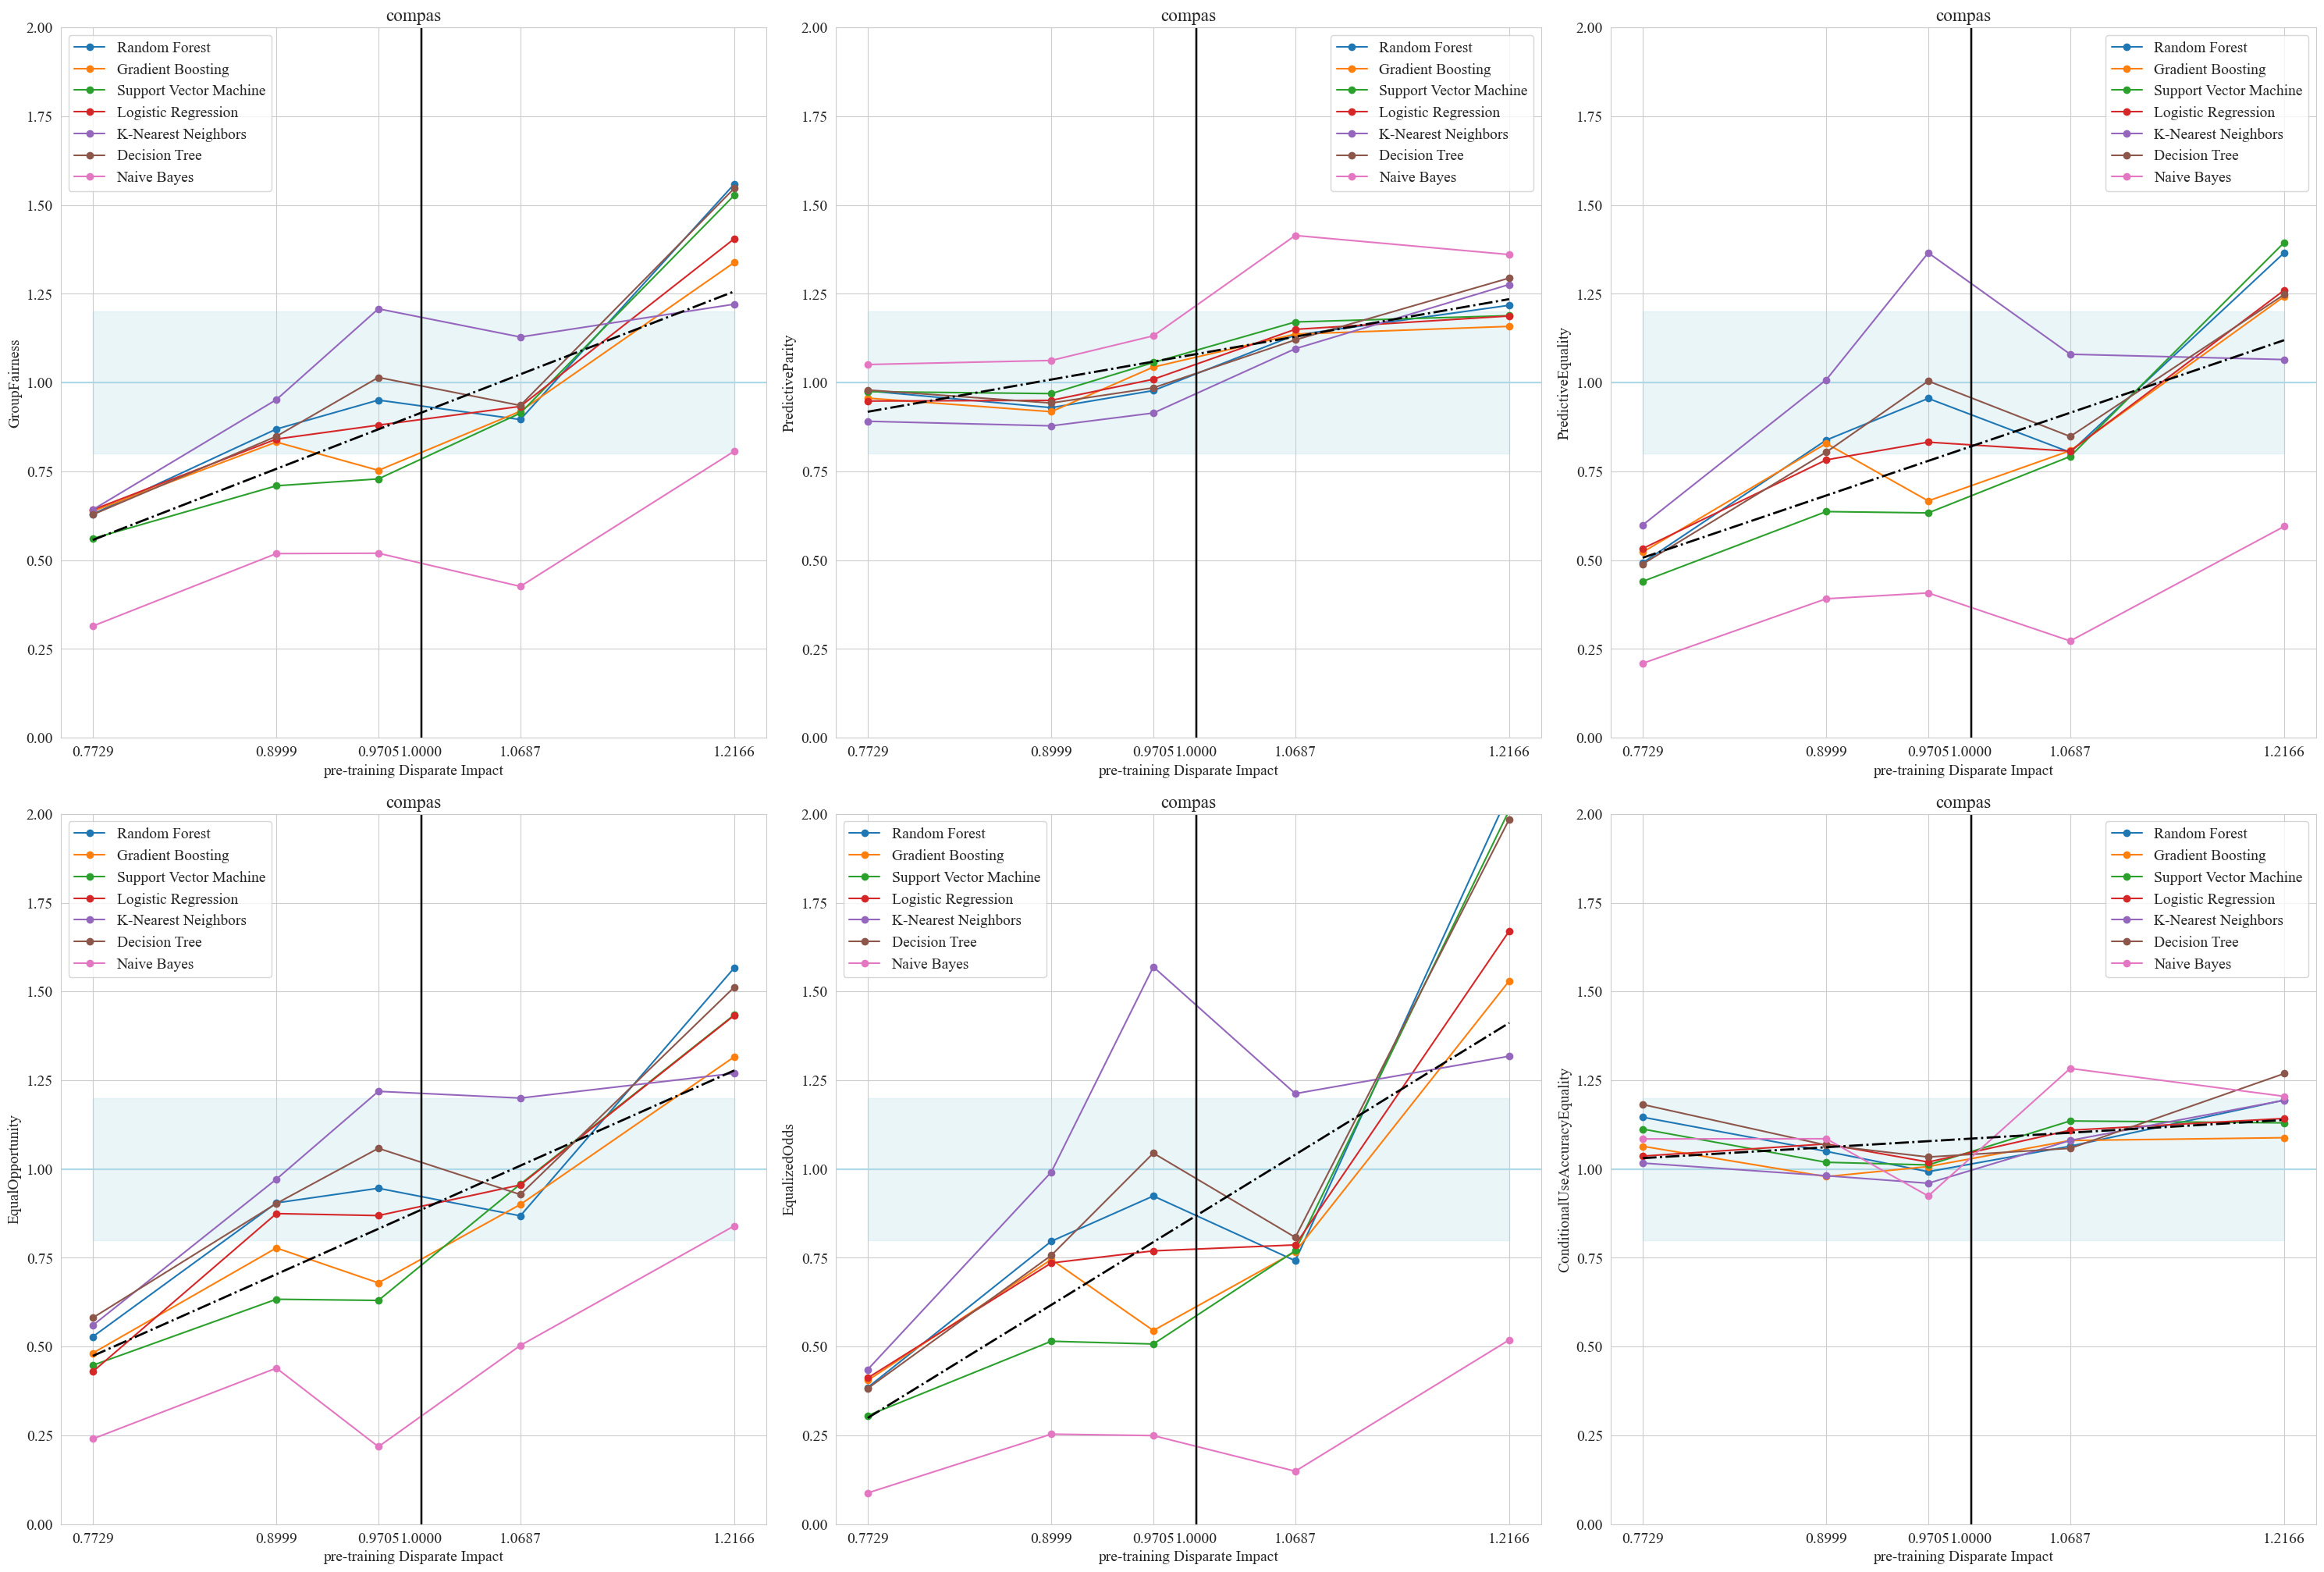

In [7]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()

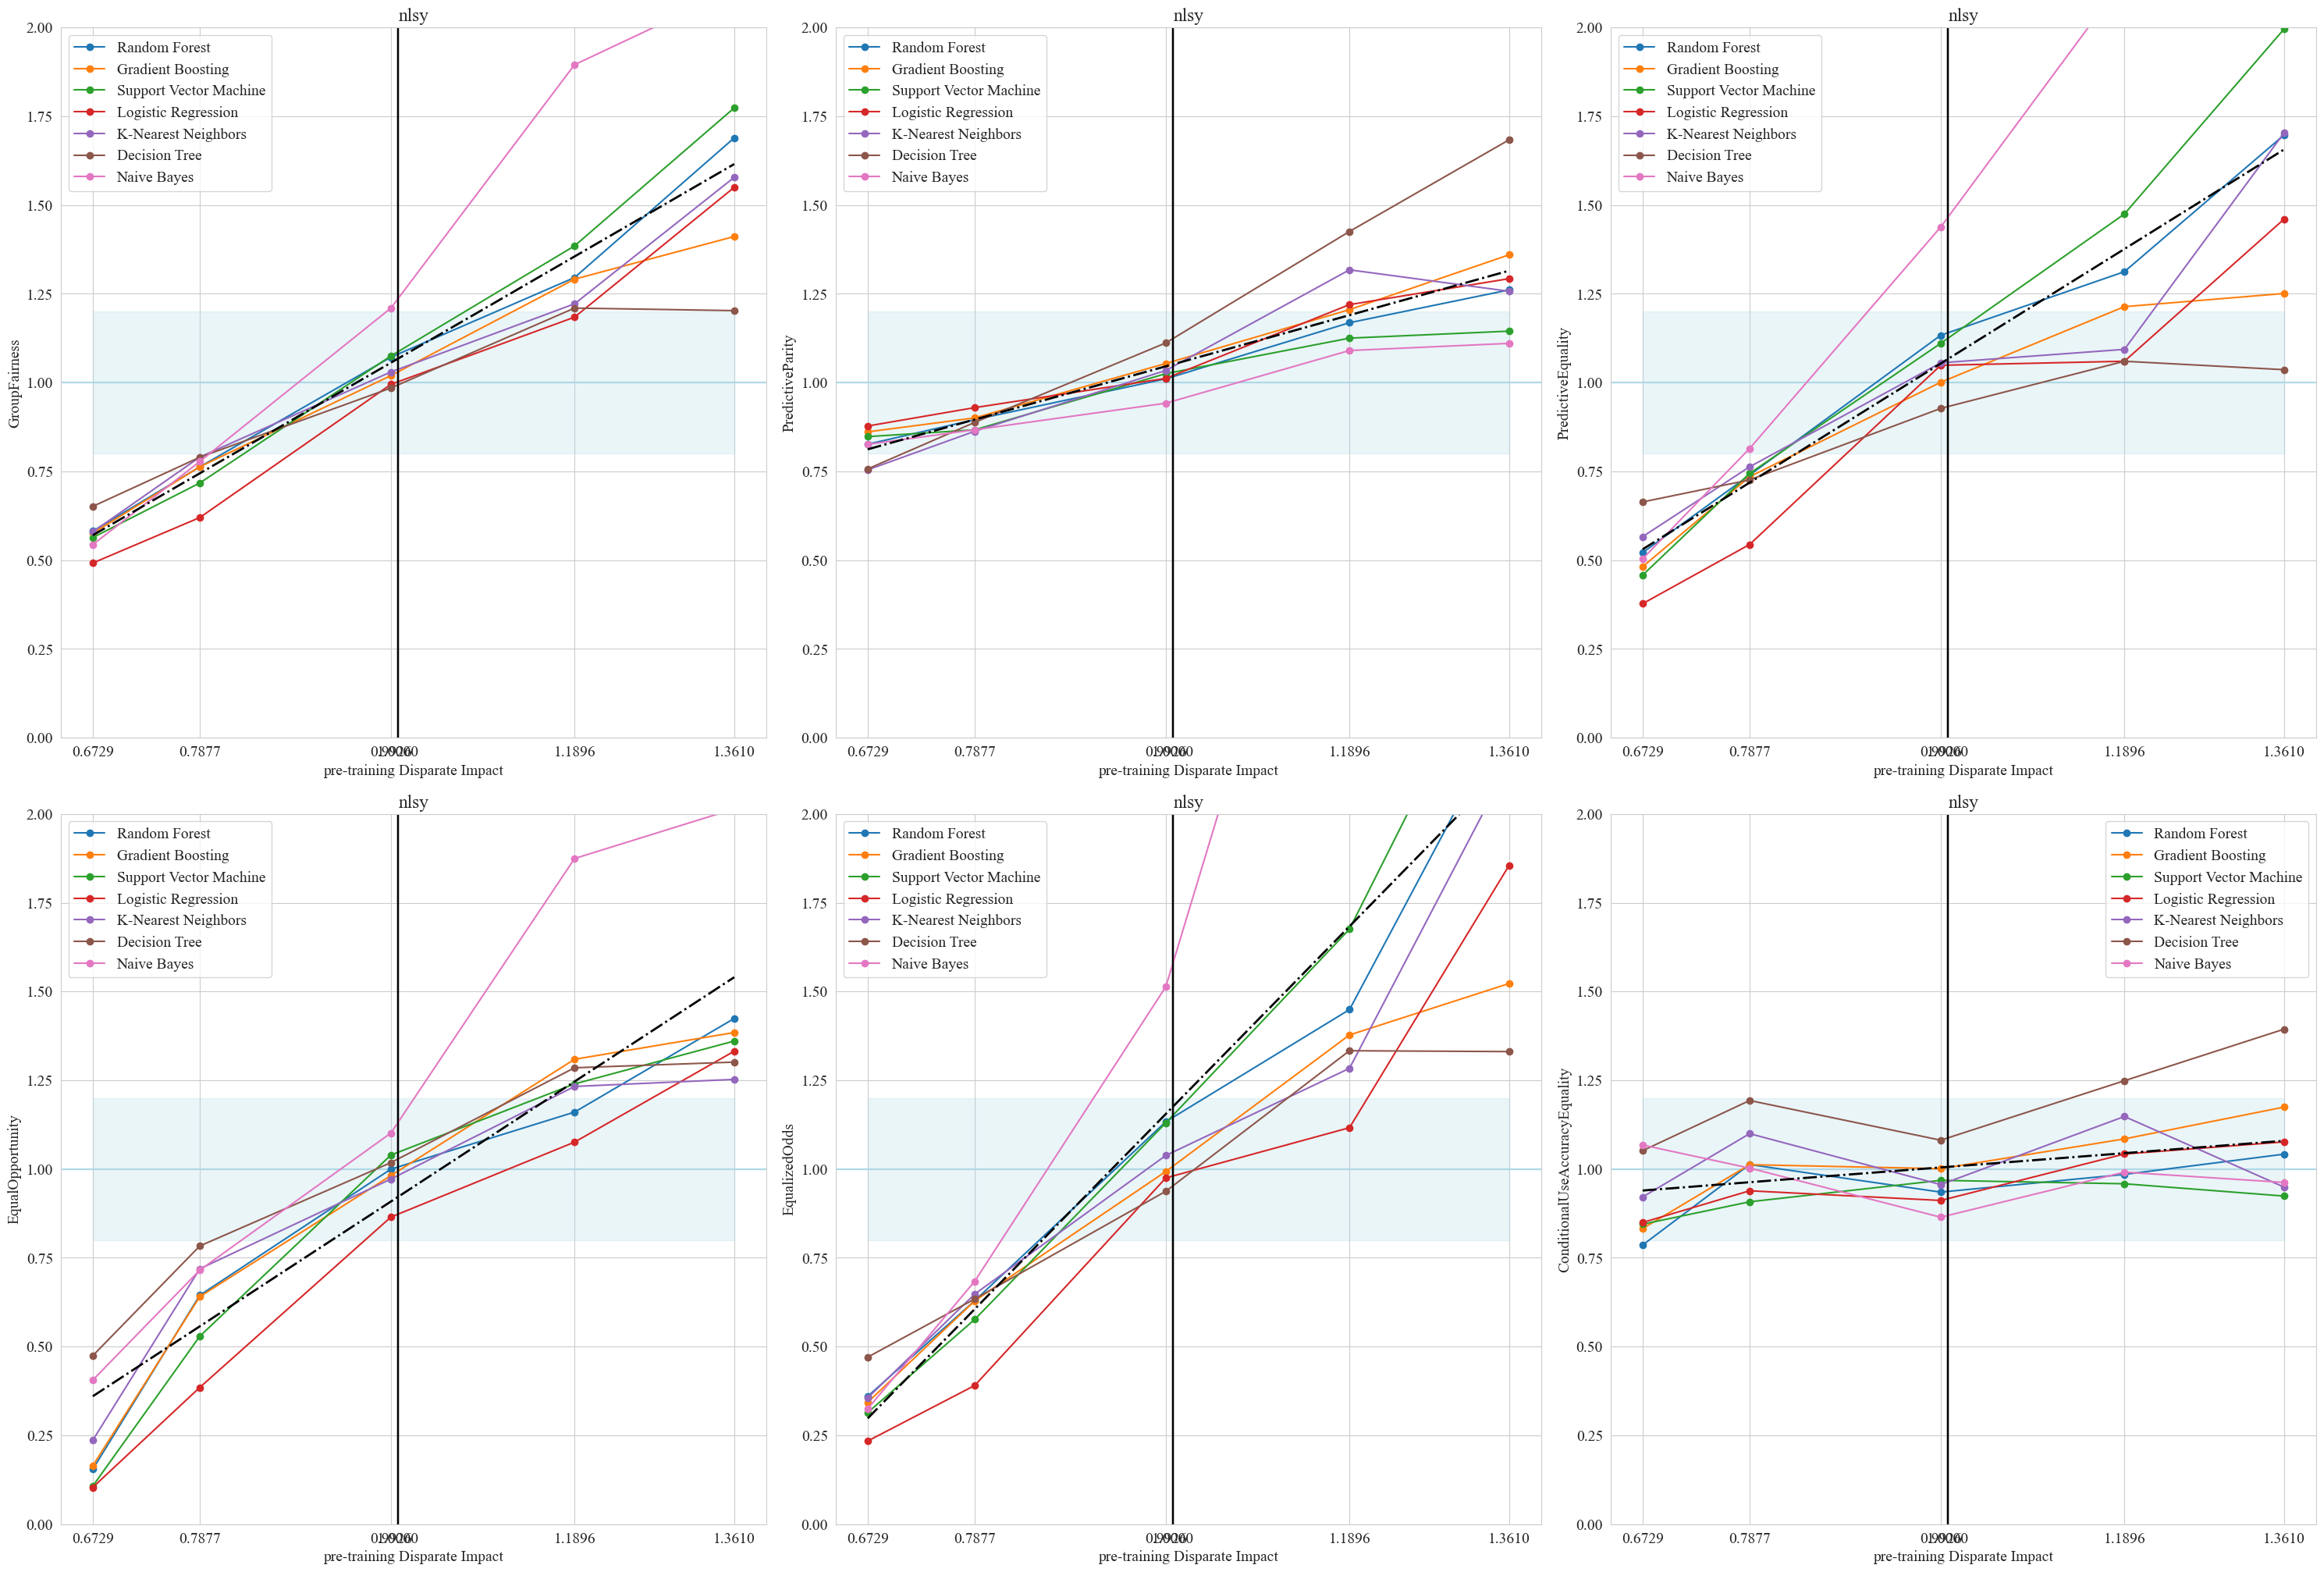

In [10]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()


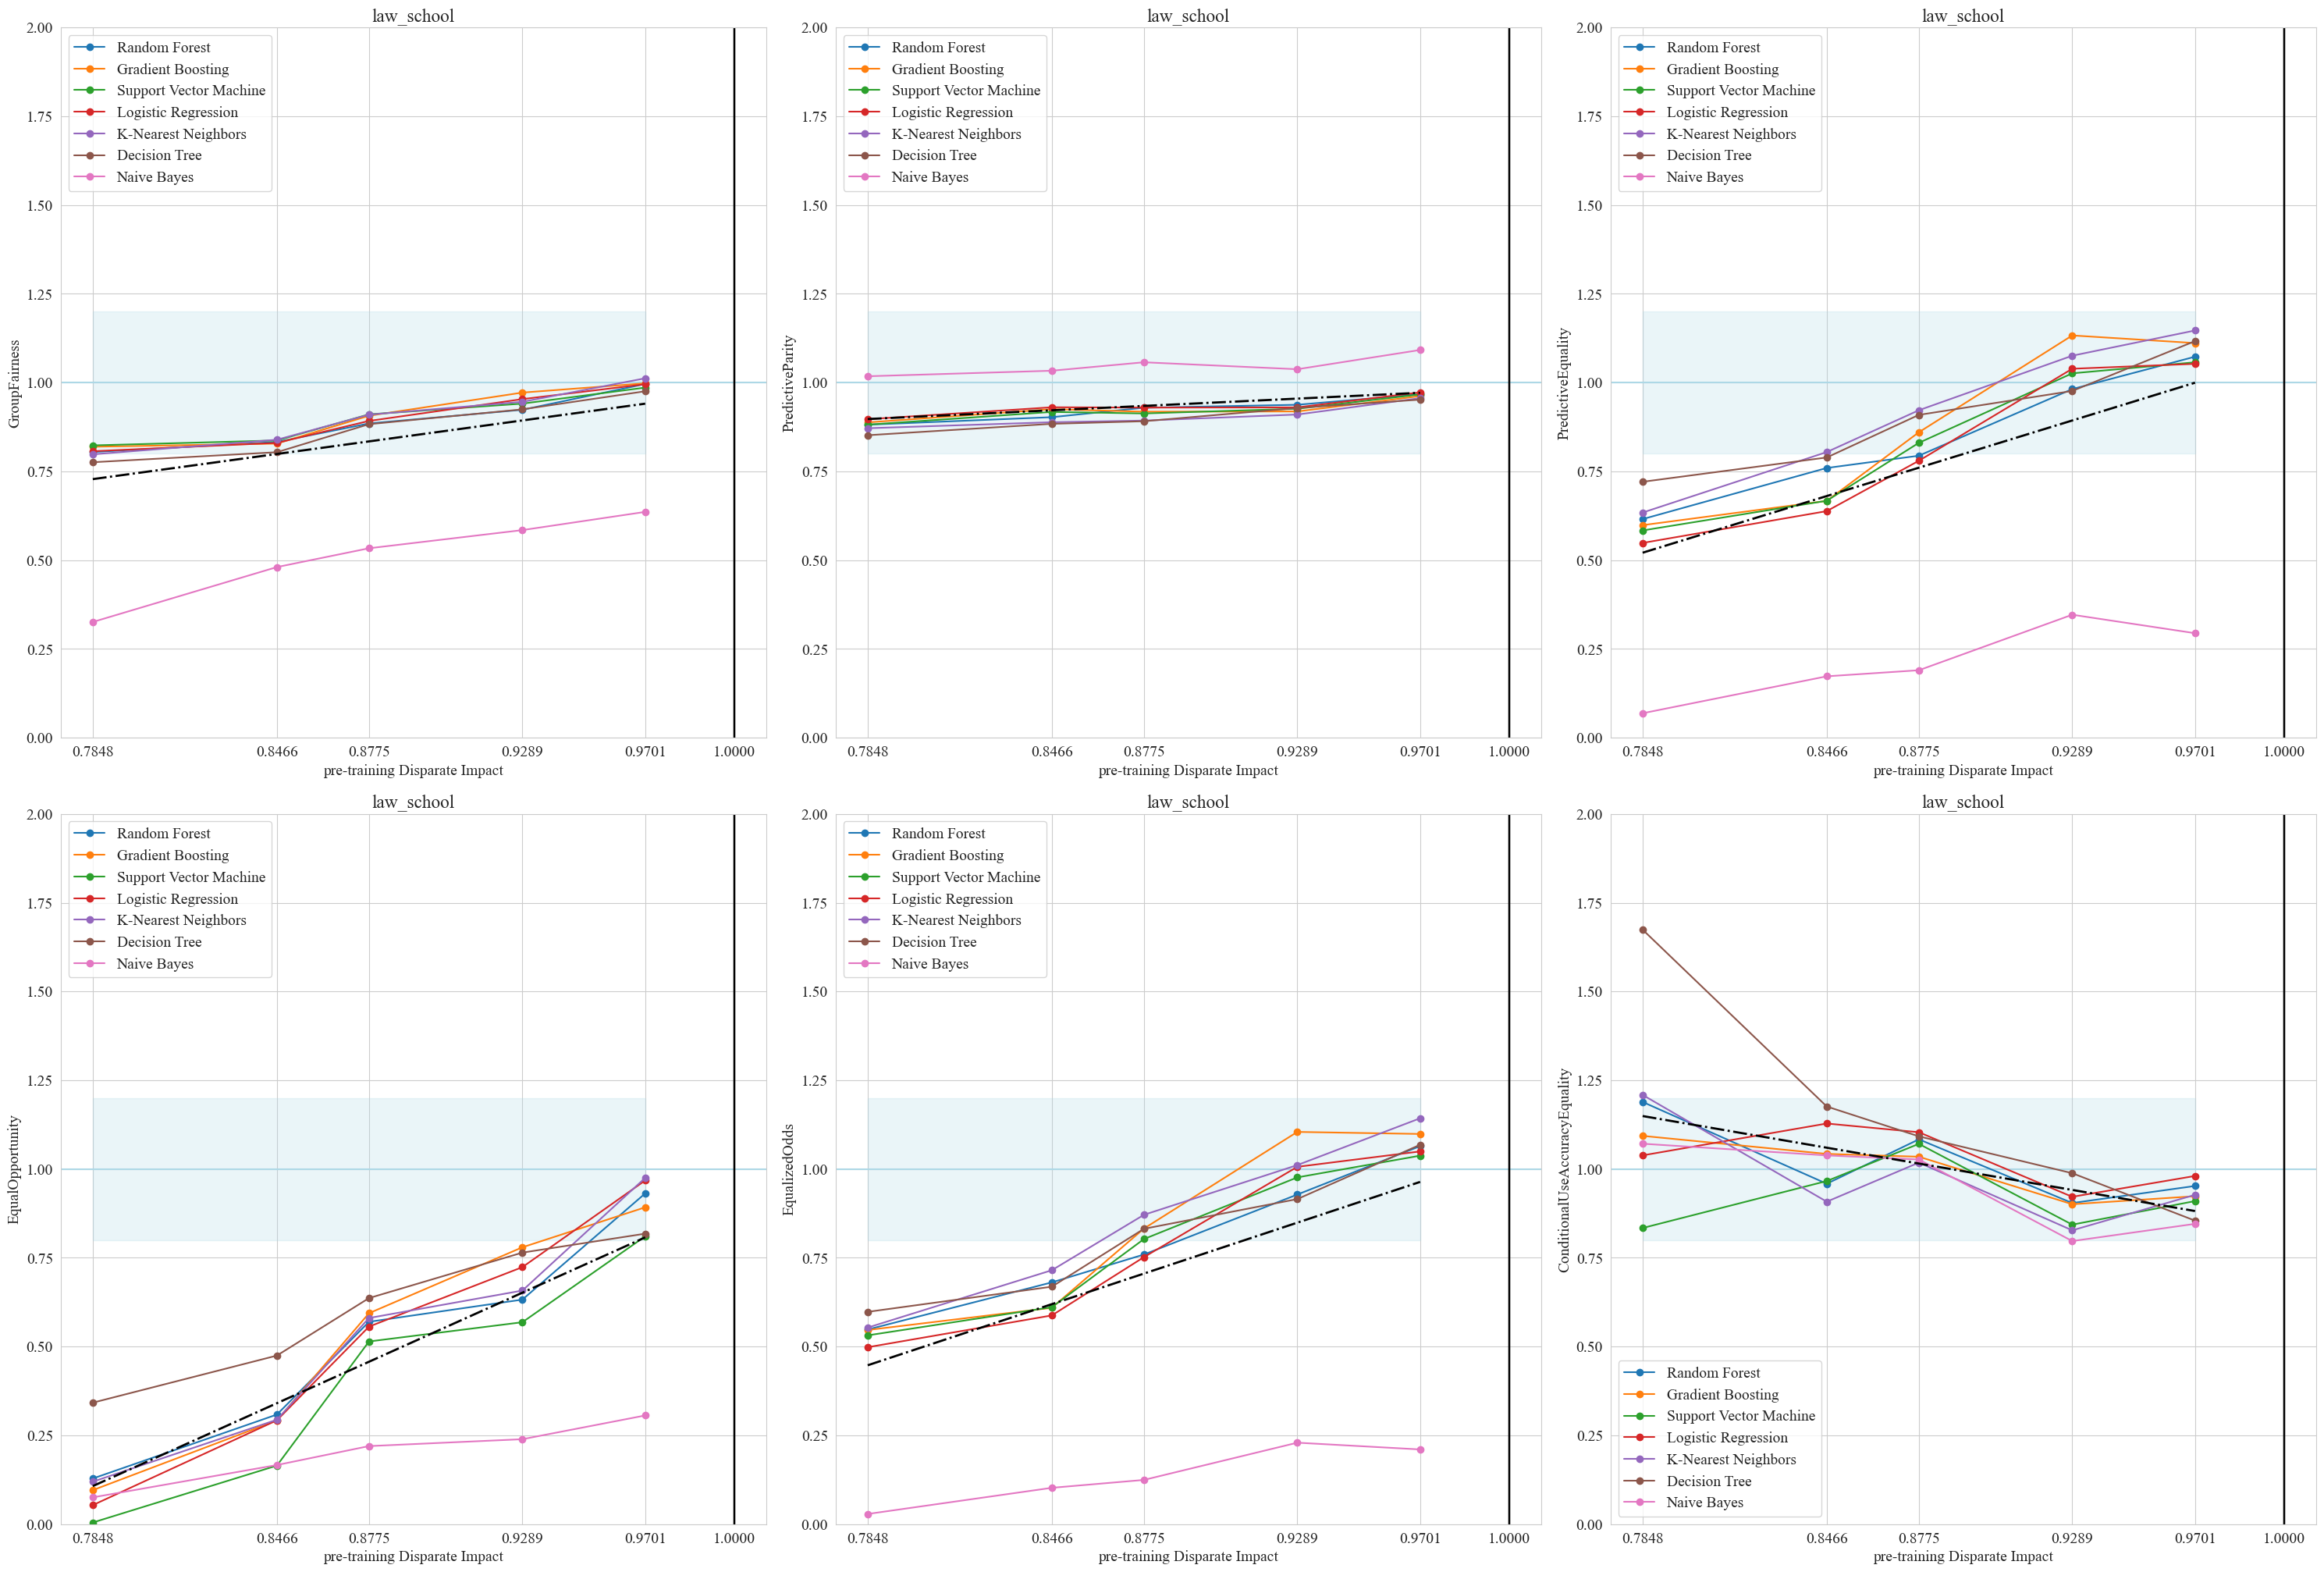

In [13]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()

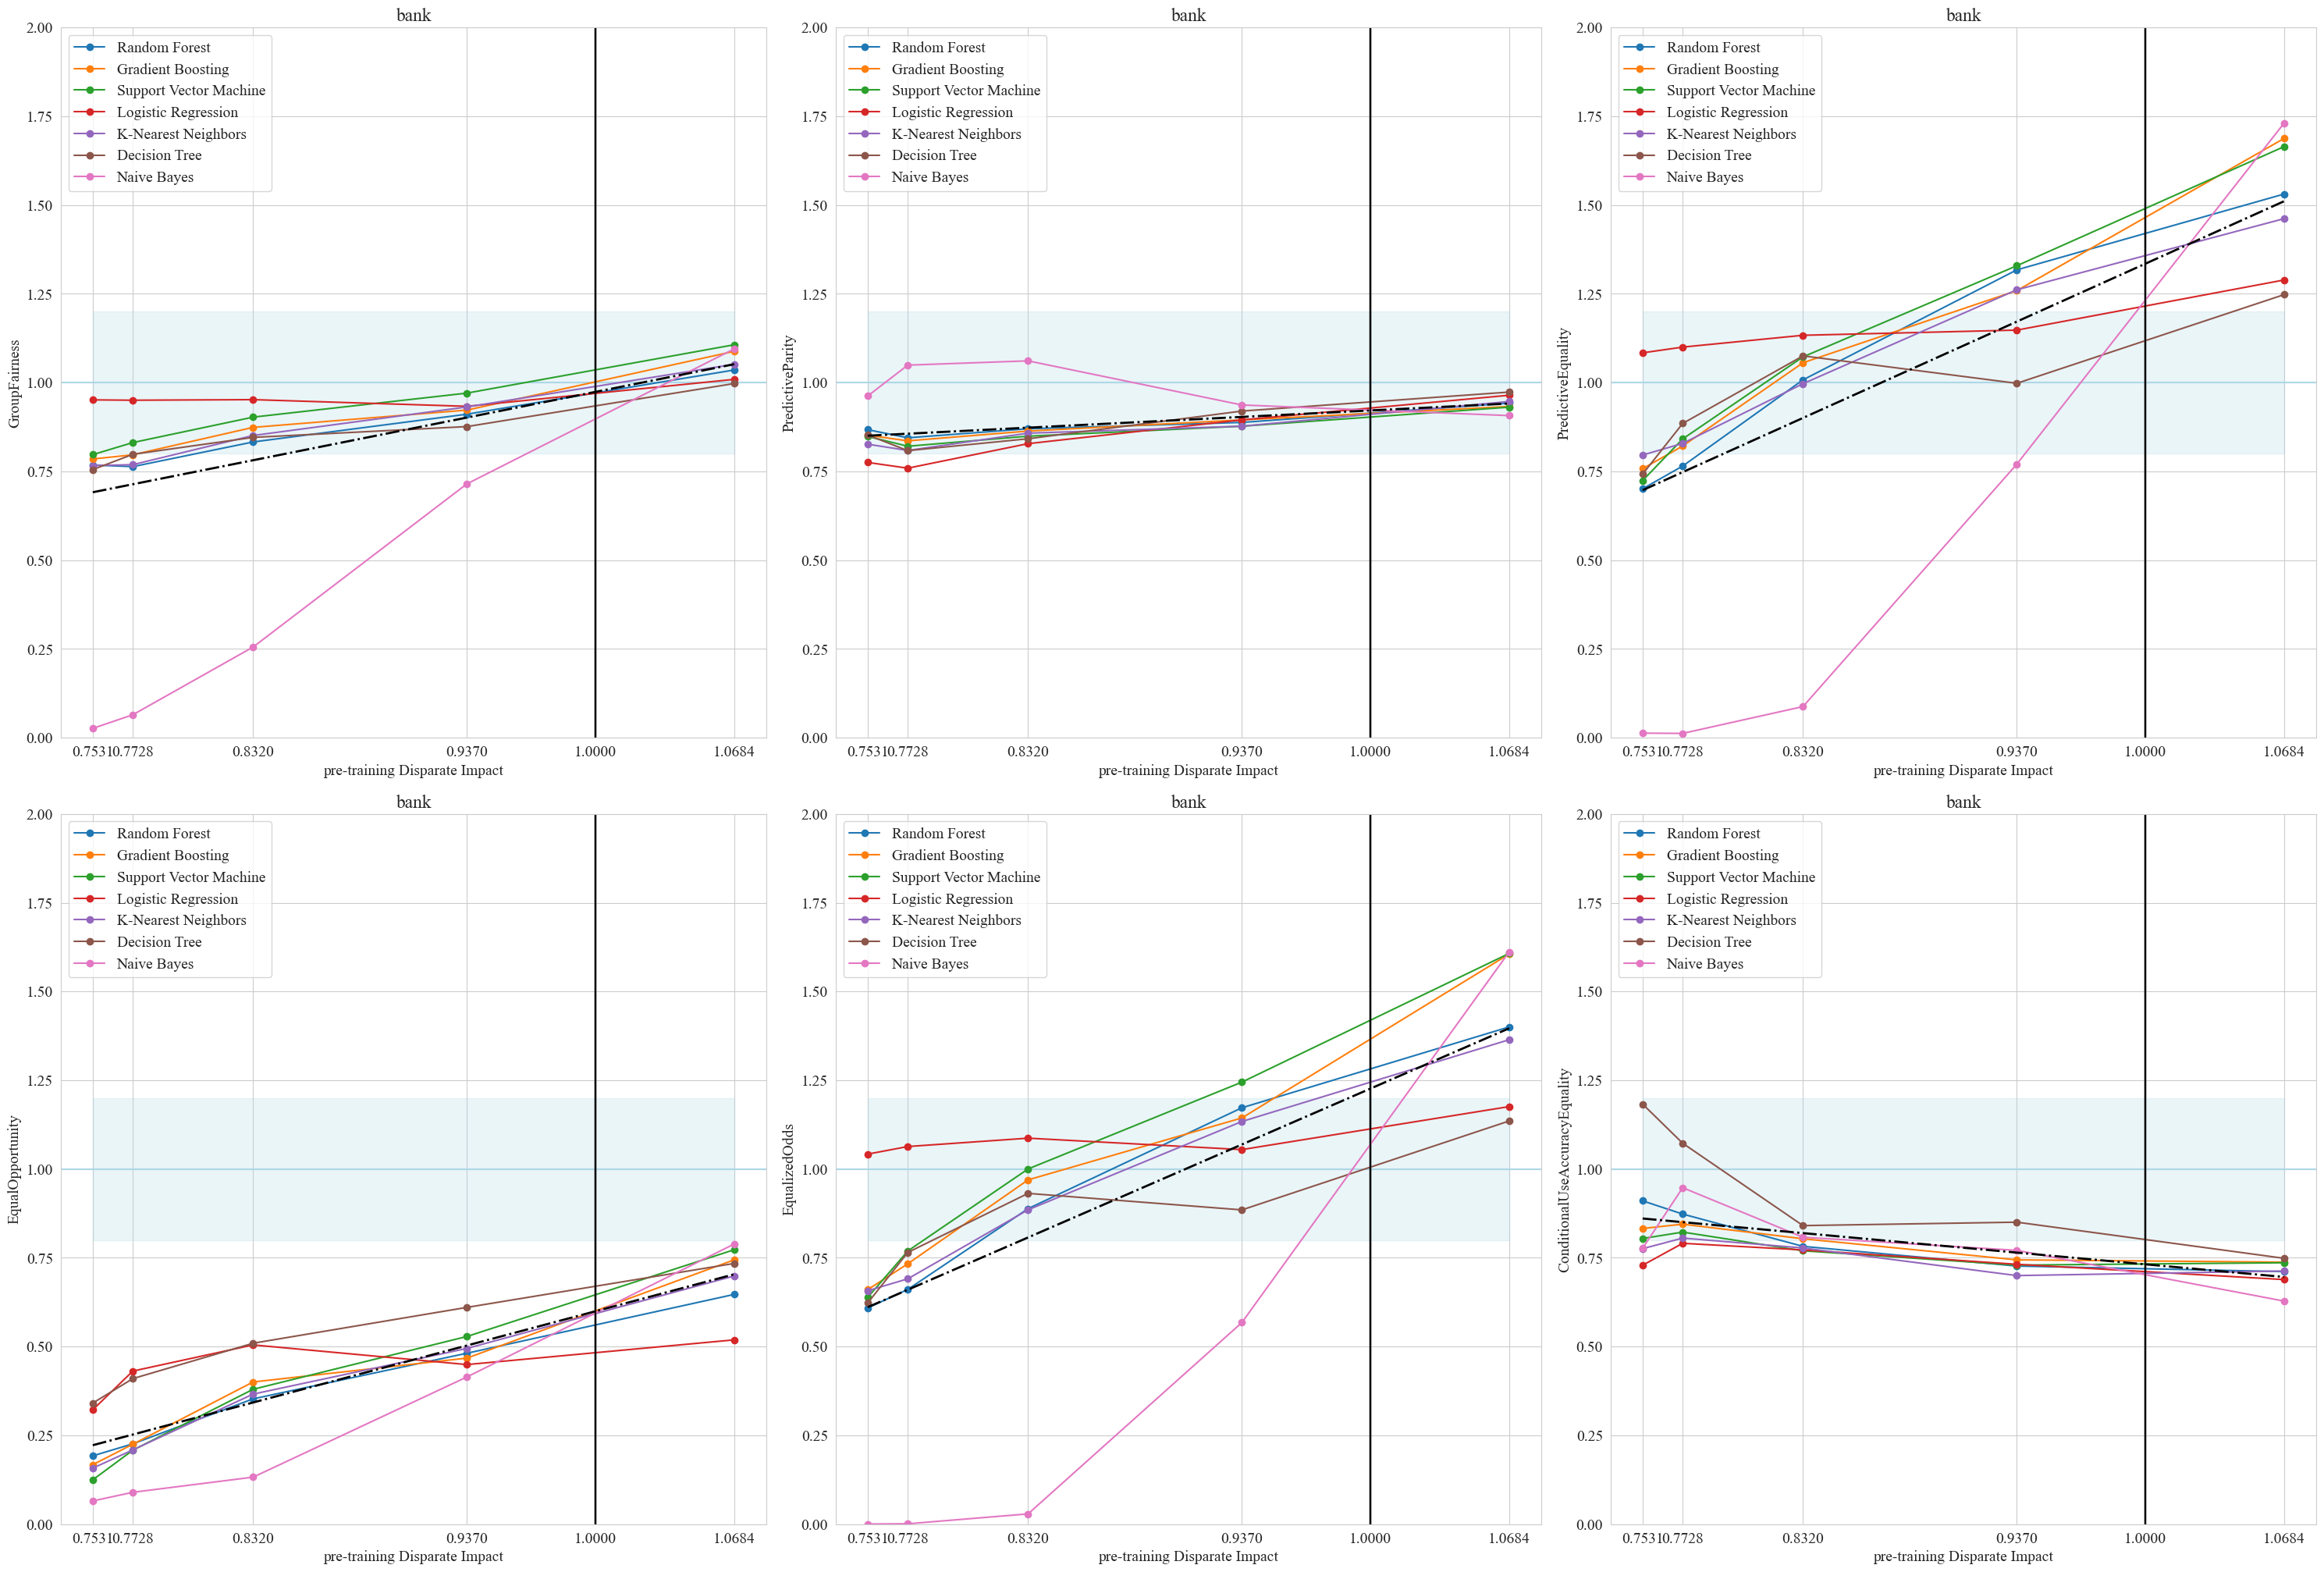

In [16]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()

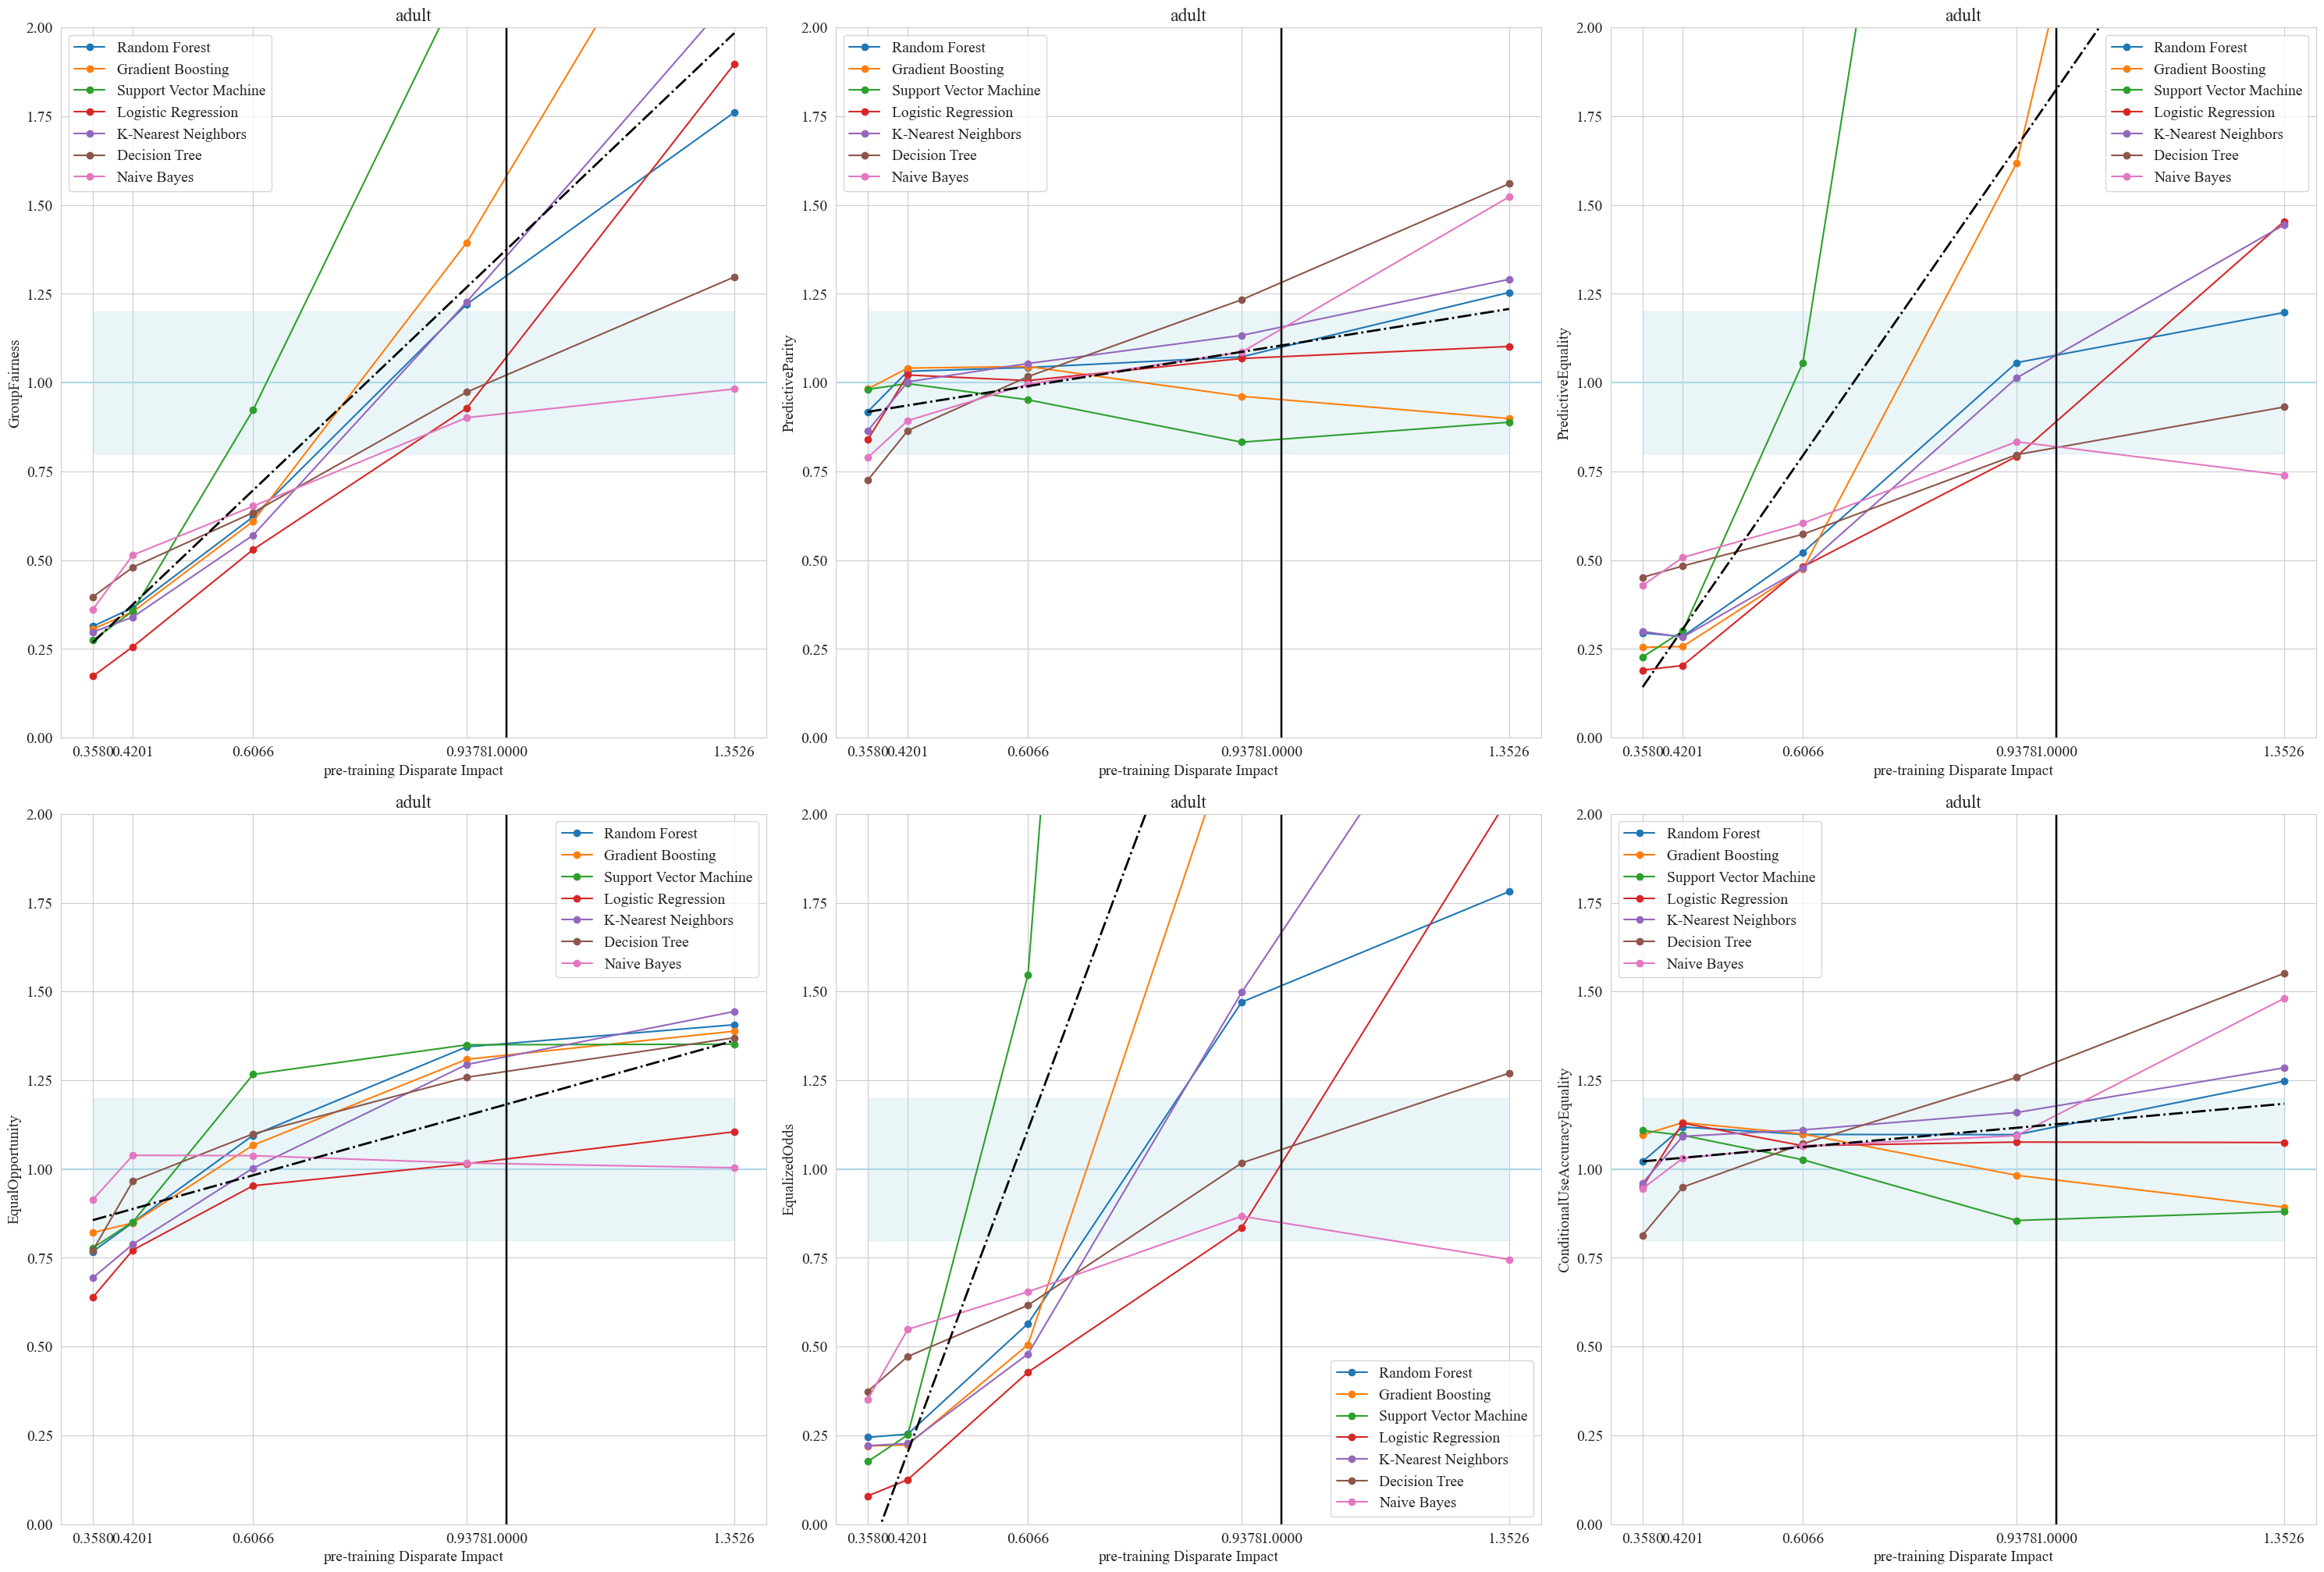

In [21]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()

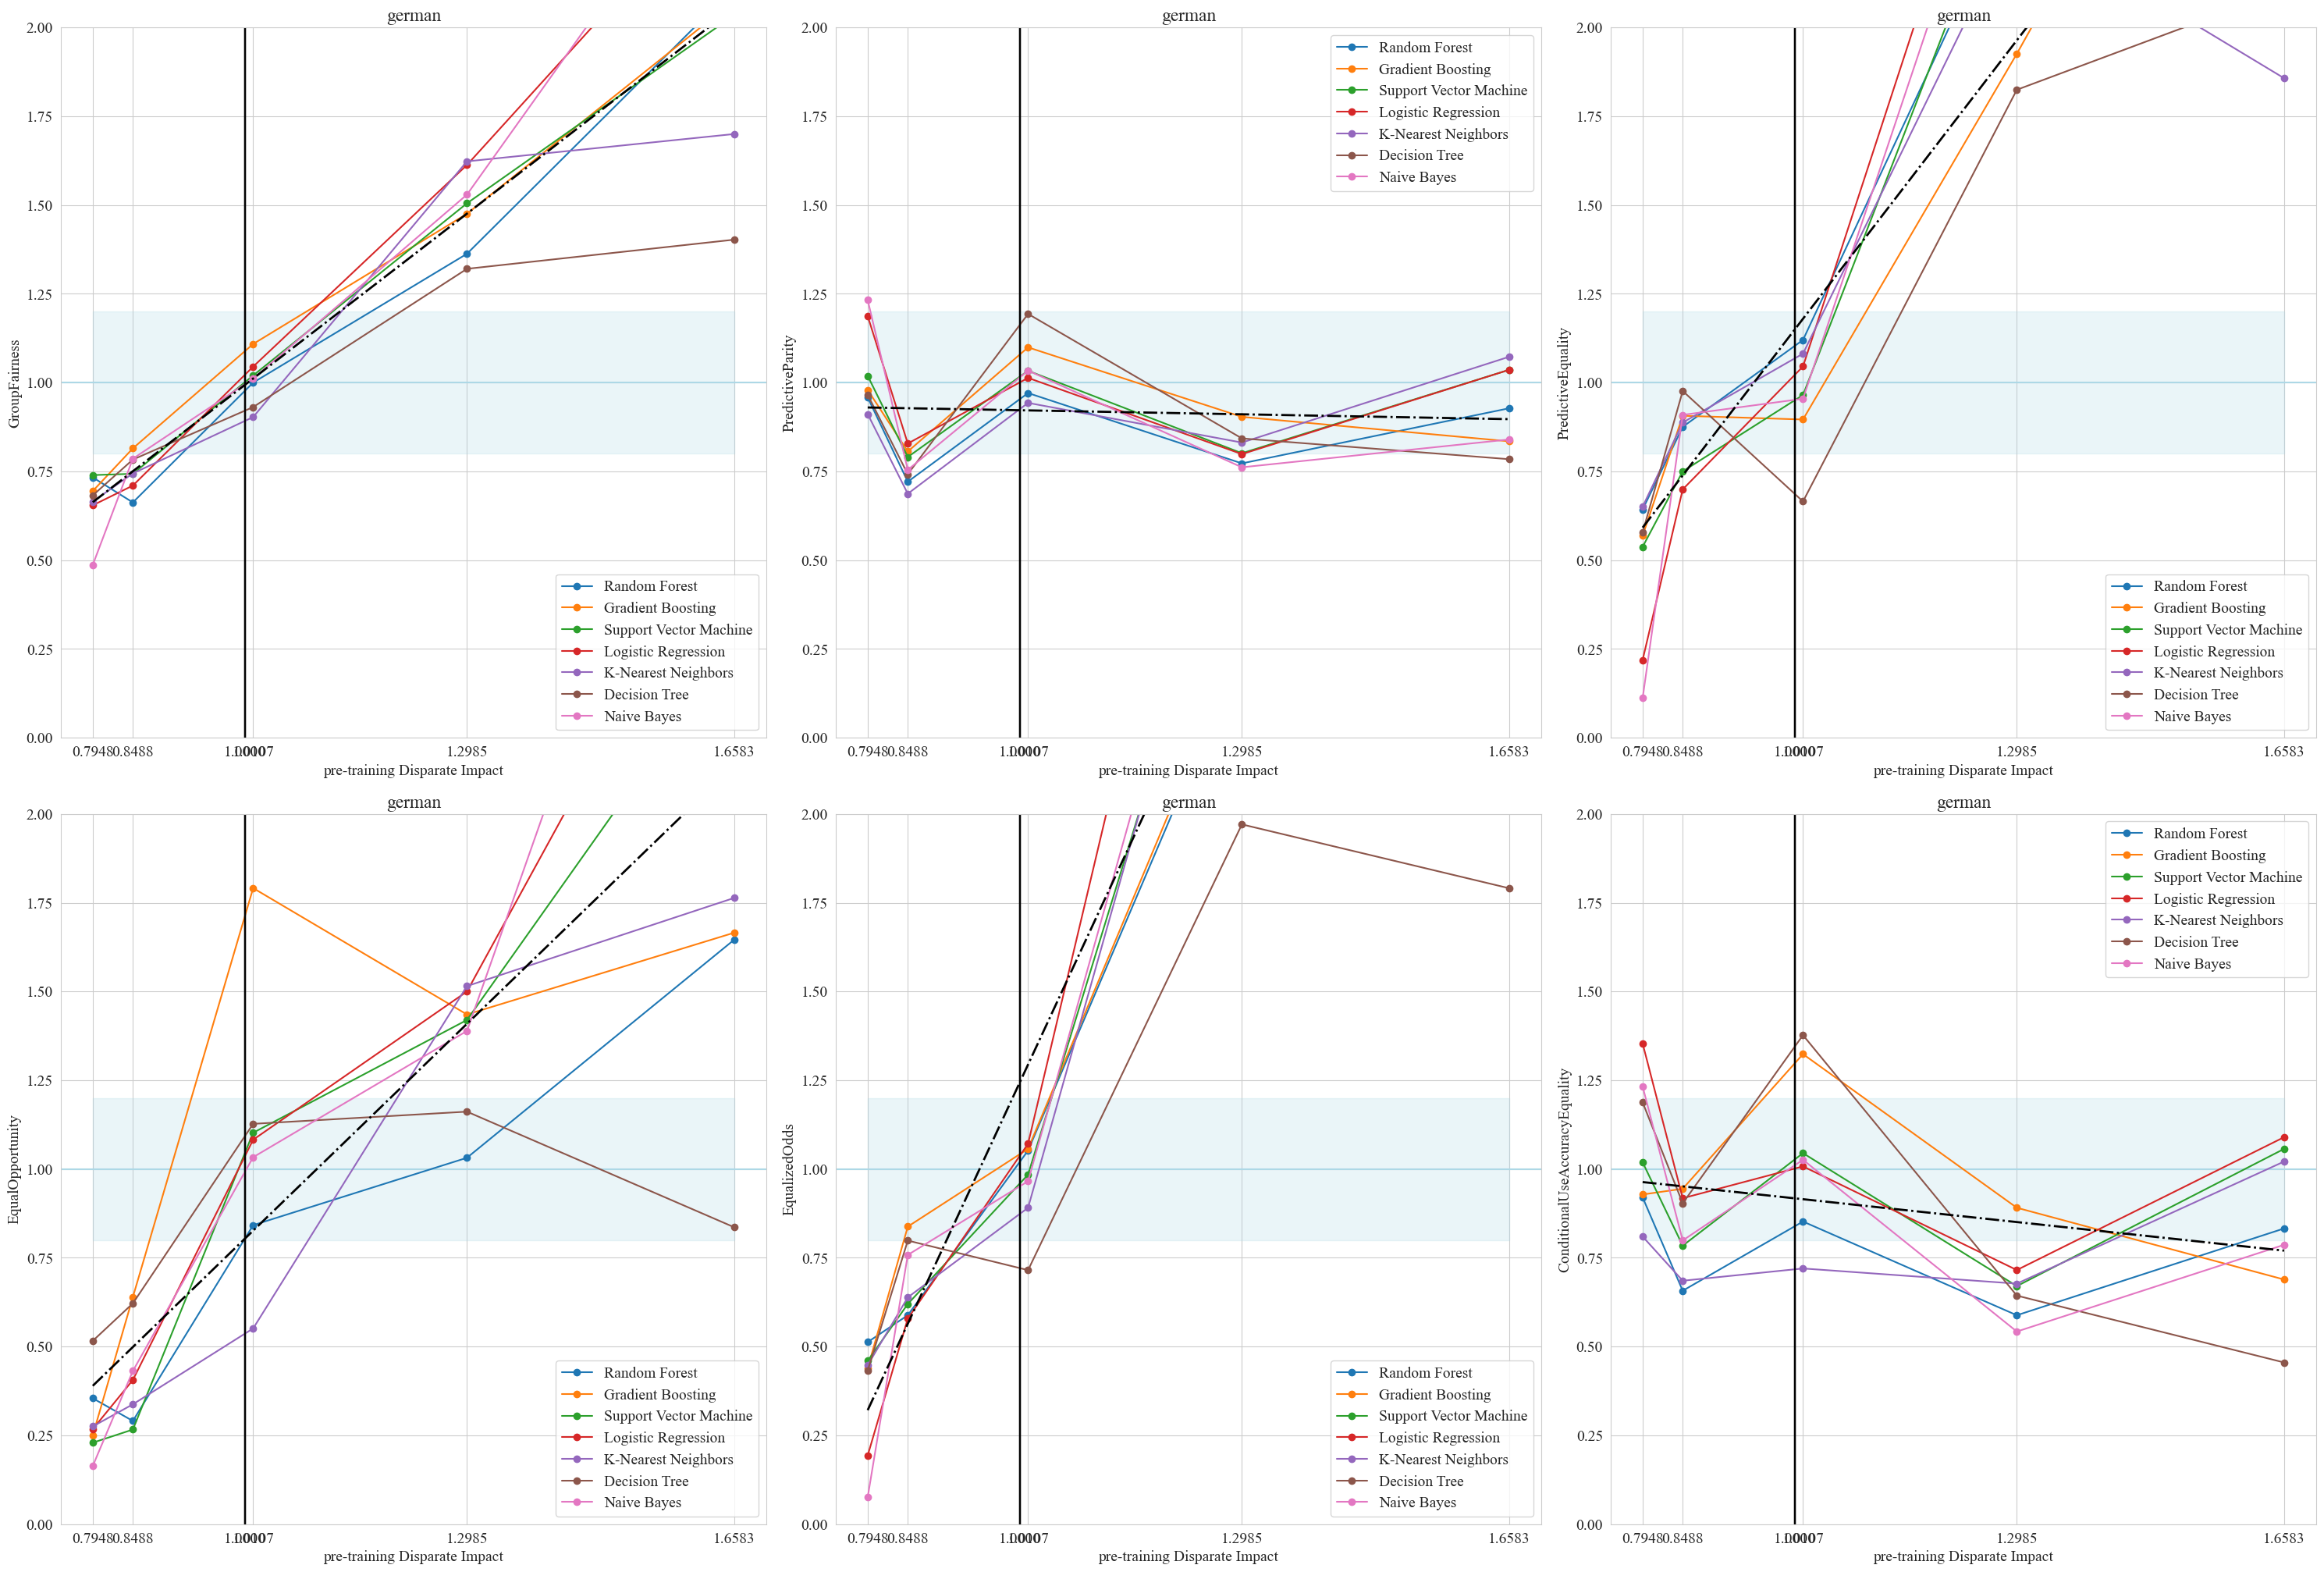

In [24]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()

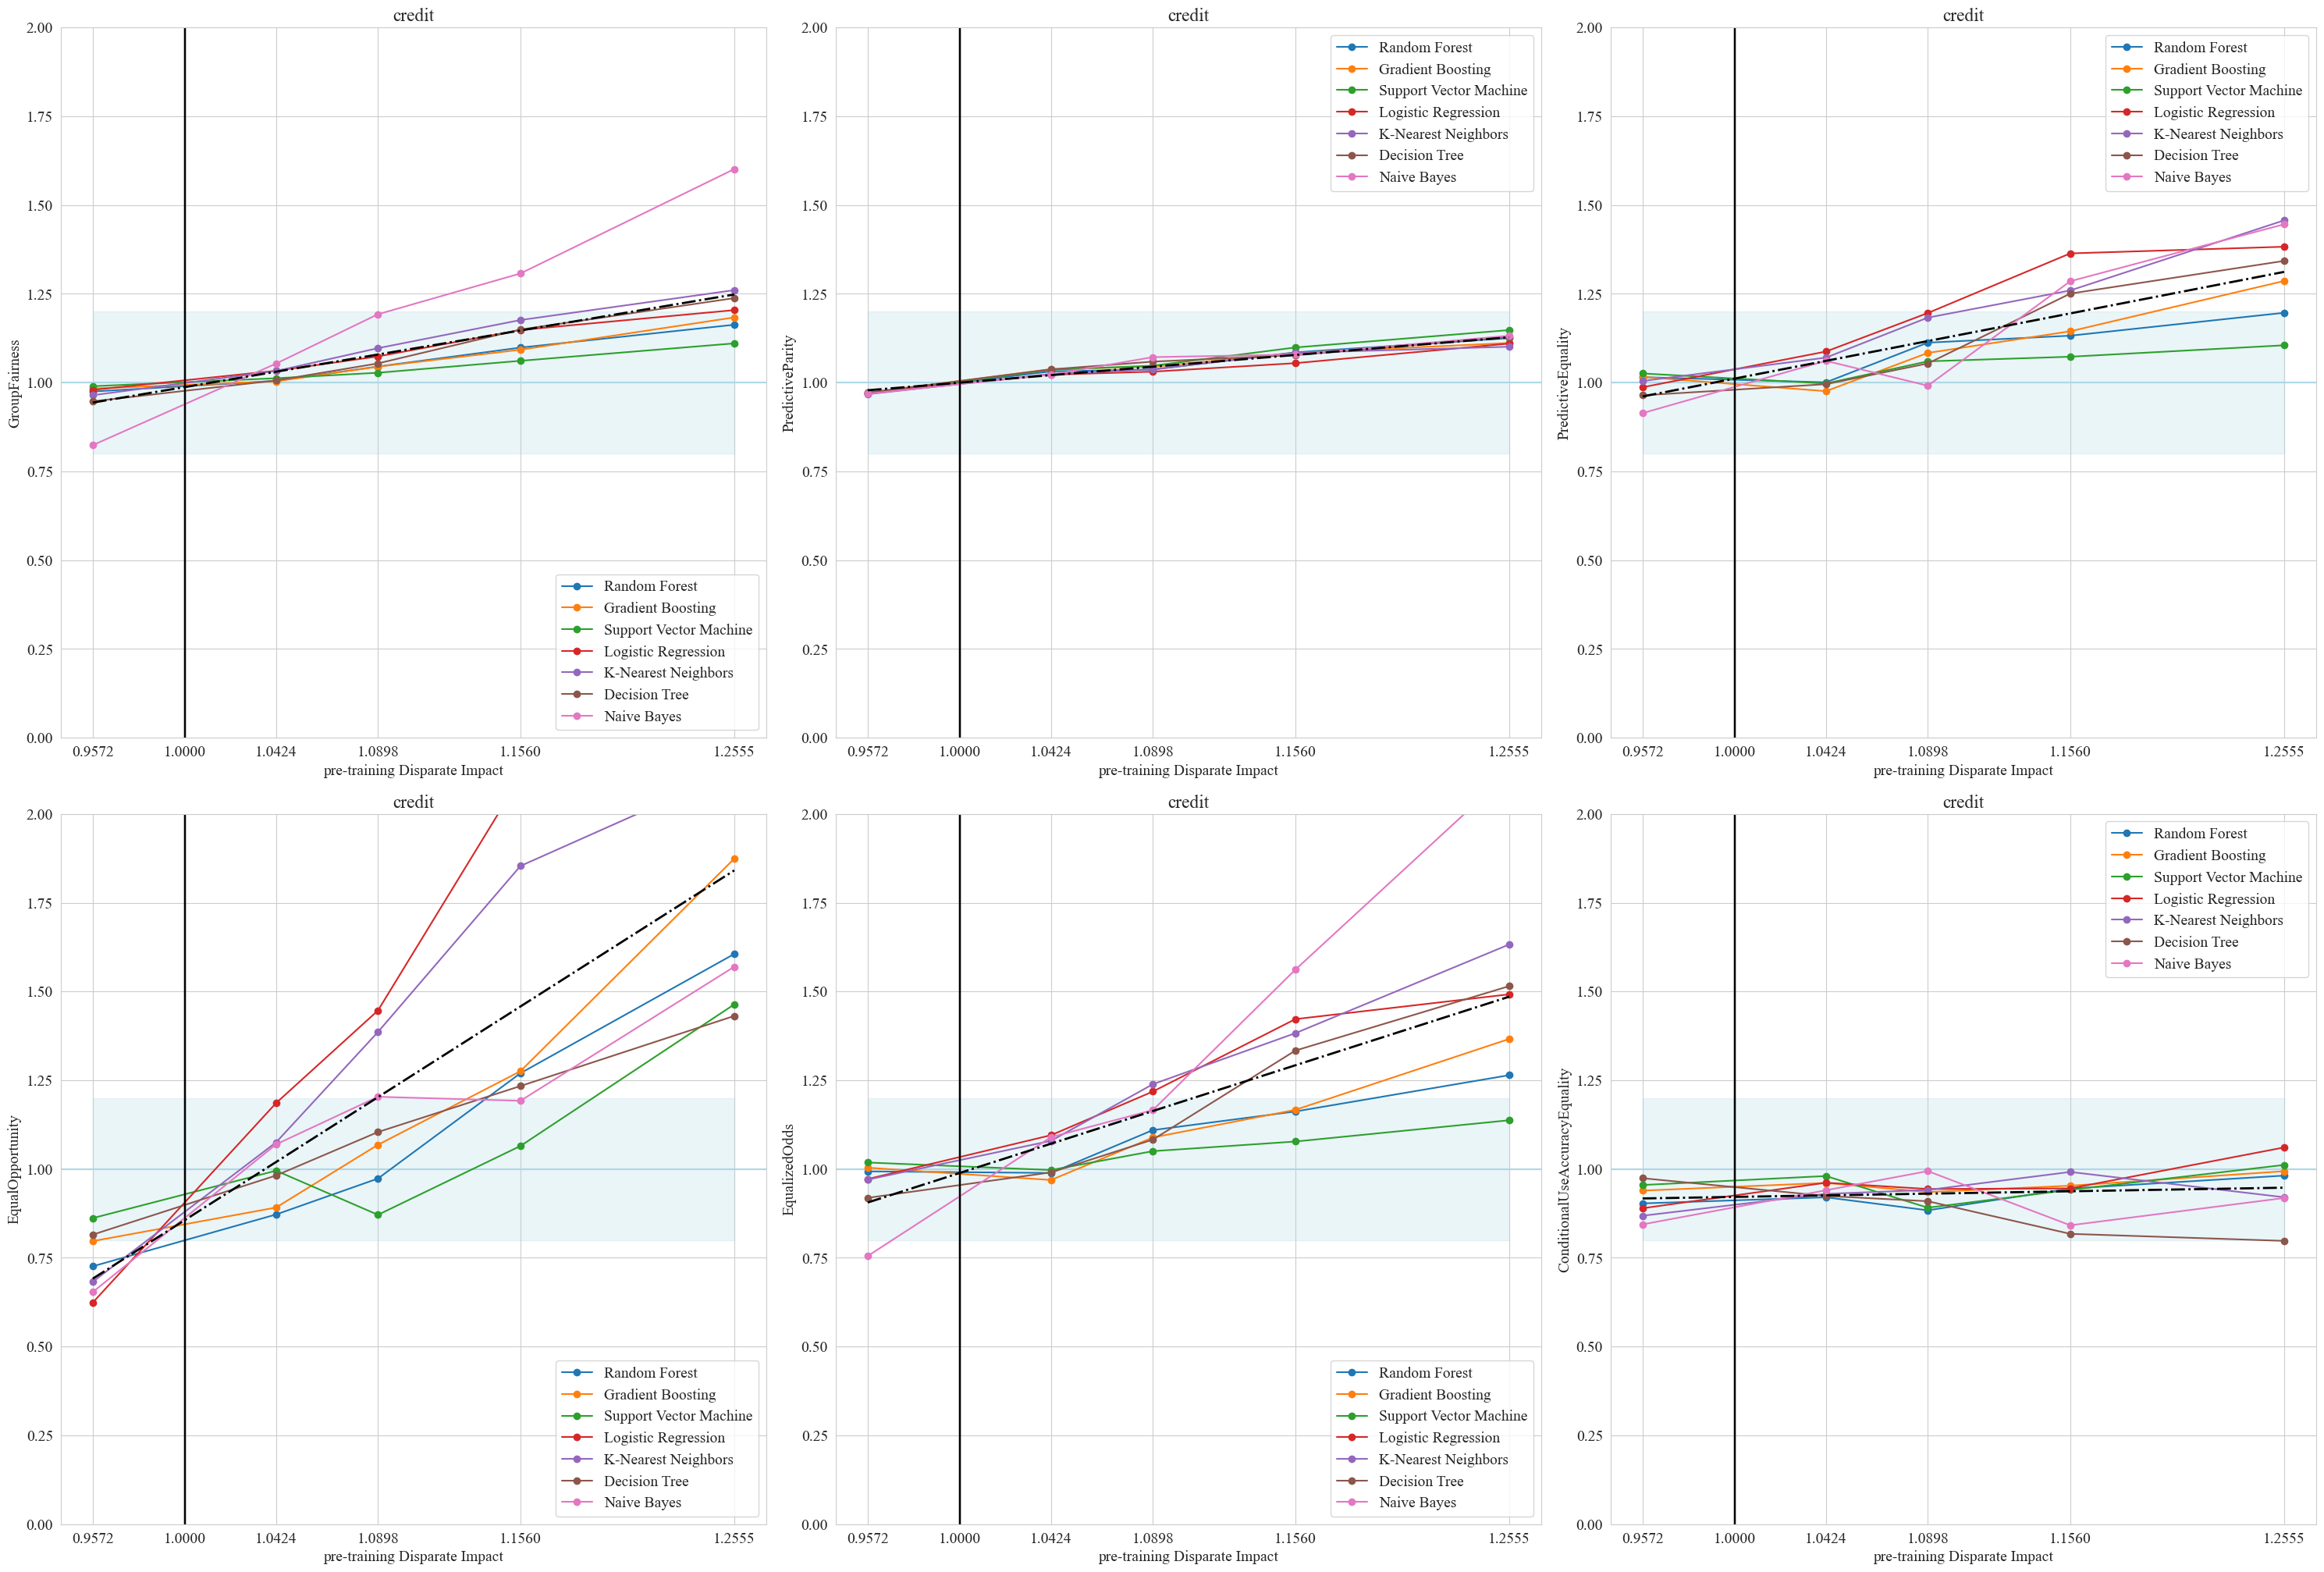

In [27]:
plt.figure(figsize=(30, 40))

for k, metric in metrics.items():
    plt.subplot(4, 3, list(metrics.keys()).index(k) + 1)
    plt.axhline(y = 1, color='lightblue', linestyle = '-')
    plt.fill_between(measure_value, 0.8, 1.2,  color='lightblue',alpha=0.25)
    for i in range(len(classifiers)):
        plt.plot(measure_value, metric[i, :], label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(measure_value + [1])
        plt.xlabel('pre-training Disparate Impact')
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0,2)

plt.tight_layout()
plt.savefig(f'plots/group_fairness_vs_bias_{dataset_name}.svg', format='svg')
plt.show()